# XGBoost classifier of OK states of anesthesia

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)

import numpy as np

## Load data 

The data is stored within 'box_plot_data' folder. Each state between 0 and 20 + 21 for unwanted data is a dictionnary key given access to a list of the metrics values computed on signal parts labelled as the key. Dictionnaries for each metrics are made at the same time iterating over recordings. As an example this means that the 3rd value of state key 10 in the lists of every metrics dictionnaries are all for the same signal part.

In [2]:
D_data = np.load('box_plot_data/D.npy', allow_pickle=True).item()

# convert data for box plots visualization
prop_delta = [D_data['D_prop_delta'][i] for i in range(22)]
prop_alpha = [D_data['D_prop_delta'][i] for i in range(22)]
prop_beta  = [D_data['D_prop_beta'][i] for i in range(22)]
prop_gamma = [D_data['D_prop_gamma'][i] for i in range(22)]

alpha_delta = [D_data['D_alpha_delta'][i] for i in range(22)]
beta_delta = [D_data['D_beta_delta'][i] for i in range(22)]
gamma_delta = [D_data['D_gamma_delta'][i] for i in range(22)]
beta_alpha = [D_data['D_beta_alpha'][i] for i in range(22)]
gamma_alpha = [D_data['D_gamma_alpha'][i] for i in range(22)]
gamma_beta = [D_data['D_gamma_alpha'][i] for i in range(22)]
hf_lf = [D_data['D_hf_lf'][i] for i in range(22)]

f_50_q = [D_data['D_50_q'][i] for i in range(22)]
f_75_q = [D_data['D_75_q'][i] for i in range(22)]
f_85_q = [D_data['D_85_q'][i] for i in range(22)]
f_95_q = [D_data['D_95_q'][i] for i in range(22)]

supp = [D_data['D_supp'][i] for i in range(22)]

line_length = [D_data['D_line_length'][i] for i in range(22)]

entropy = [D_data['D_entropy'][i] for i in range(22)]
be = [D_data['D_be'][i] for i in range(22)]

f_central  = [D_data['D_f_central'][i] for i in range(22)]

### Visualize distributions

Text(0.5, 1.0, 'prop_gamma')

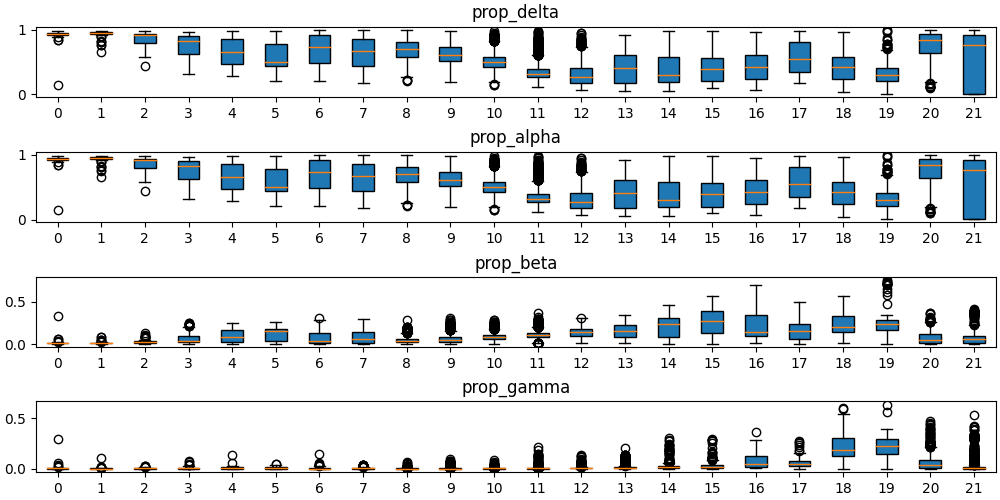

In [3]:
fig, axes = plt.subplots(4, constrained_layout = True)

axes[0].boxplot(prop_delta, positions=range(22), patch_artist=True)
axes[0].set_title('prop_delta')
axes[1].boxplot(prop_alpha, positions=range(22), patch_artist=True)
axes[1].set_title('prop_alpha')
axes[2].boxplot(prop_beta, positions=range(22), patch_artist=True)
axes[2].set_title('prop_beta')
axes[3].boxplot(prop_gamma, positions=range(22), patch_artist=True)
axes[3].set_title('prop_gamma')

Text(0.5, 1.0, 'hf_lf')

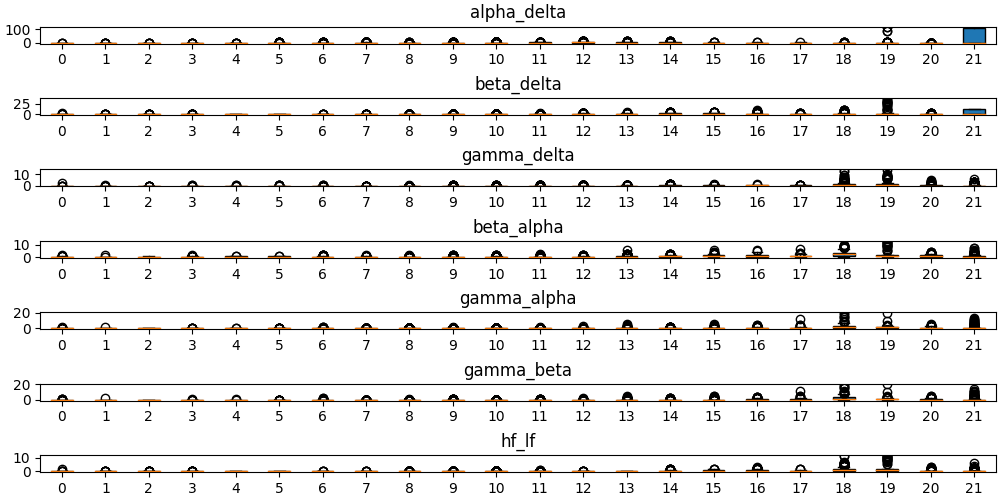

In [4]:
for i in range(4):
    axes[i].set_ylim(0,1)

fig, axes = plt.subplots(7, constrained_layout = True)

axes[0].boxplot(alpha_delta, positions=range(22), patch_artist=True)
axes[0].set_title('alpha_delta')
axes[1].boxplot(beta_delta, positions=range(22), patch_artist=True)
axes[1].set_title('beta_delta')
axes[2].boxplot(gamma_delta, positions=range(22), patch_artist=True)
axes[2].set_title('gamma_delta')
axes[3].boxplot(beta_alpha, positions=range(22), patch_artist=True)
axes[3].set_title('beta_alpha')
axes[4].boxplot(gamma_alpha, positions=range(22), patch_artist=True)
axes[4].set_title('gamma_alpha')
axes[5].boxplot(gamma_beta, positions=range(22), patch_artist=True)
axes[5].set_title('gamma_beta')
axes[6].boxplot(hf_lf, positions=range(22), patch_artist=True)
axes[6].set_title('hf_lf')

Text(0.5, 1.0, 'f_central')

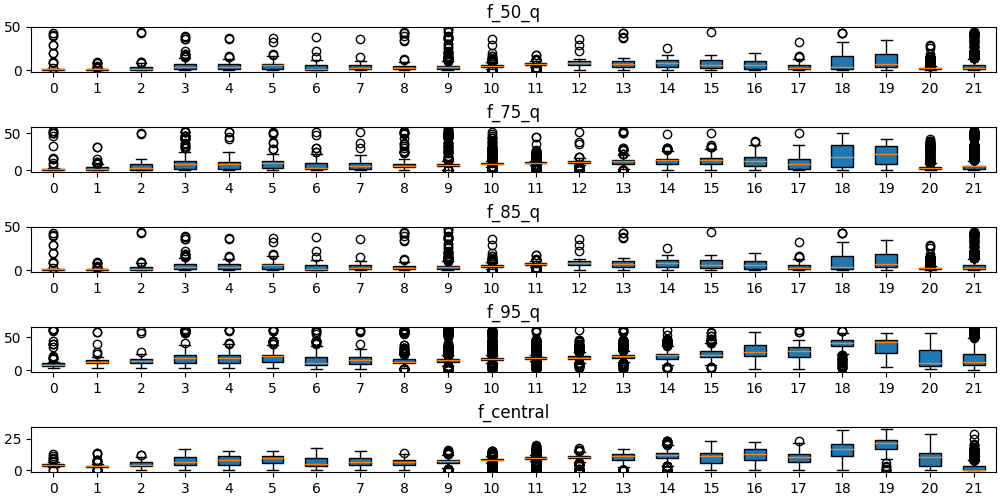

In [5]:
for i in range(7):
    axes[i].set_ylim(0,1)

fig, axes = plt.subplots(5, constrained_layout = True)

axes[0].boxplot(f_50_q, positions=range(22), patch_artist=True)
axes[0].set_title('f_50_q')
axes[1].boxplot(f_75_q, positions=range(22), patch_artist=True)
axes[1].set_title('f_75_q')
axes[2].boxplot(f_50_q, positions=range(22), patch_artist=True)
axes[2].set_title('f_85_q')
axes[3].boxplot(f_95_q, positions=range(22), patch_artist=True)
axes[3].set_title('f_95_q')
axes[4].boxplot(f_central, positions=range(22), patch_artist=True)
axes[4].set_title('f_central')


Text(0.5, 1.0, 'be')

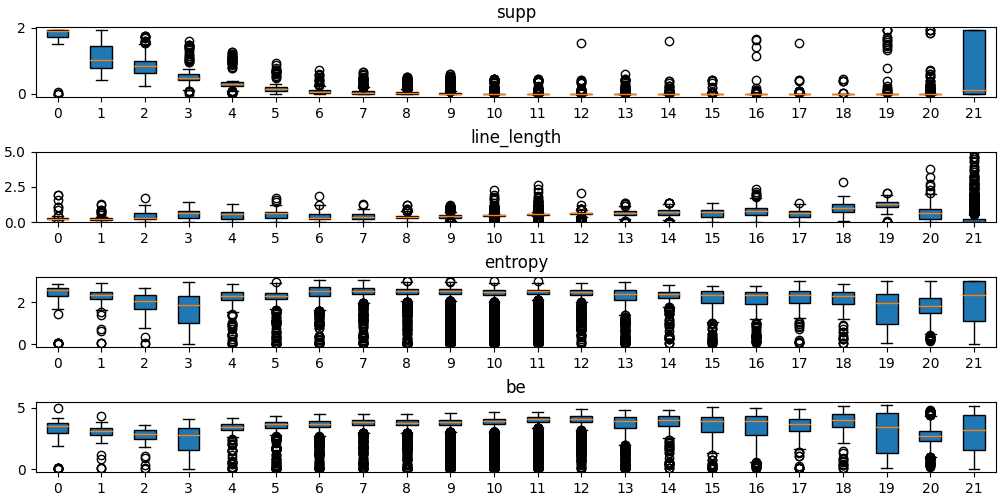

In [6]:
for i in range(4):
    axes[i].set_ylim(0,20)

fig, axes = plt.subplots(4, constrained_layout = True)

axes[0].boxplot(supp, positions=range(22), patch_artist=True)
axes[0].set_title('supp')
axes[1].boxplot(line_length, positions=range(22), patch_artist=True)
axes[1].set_title('line_length')
axes[1].set_ylim(0,5)
axes[2].boxplot(entropy, positions=range(22), patch_artist=True)
axes[2].set_title('entropy')
axes[3].boxplot(be, positions=range(22), patch_artist=True)
axes[3].set_title('be')

### Visualize data only in OK range

In [7]:
start, end = 6 , 13  # starting state to end state + 1

Text(0.5, 1.0, 'prop_gamma')

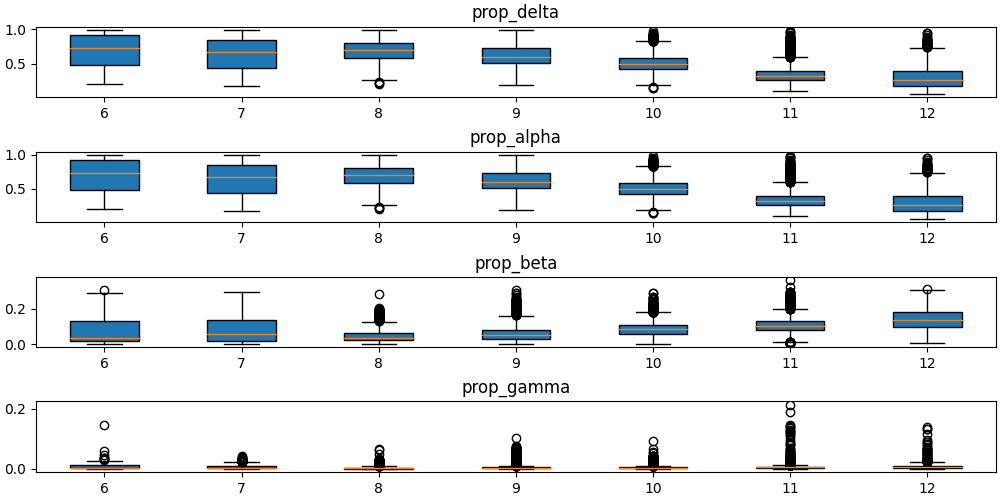

In [8]:
fig, axes = plt.subplots(4, constrained_layout = True)

axes[0].boxplot(prop_delta[start : end], positions=range(start, end), patch_artist=True)
axes[0].set_title('prop_delta')
axes[1].boxplot(prop_alpha[start : end], positions=range(start, end), patch_artist=True)
axes[1].set_title('prop_alpha')
axes[2].boxplot(prop_beta[start : end], positions=range(start, end), patch_artist=True)
axes[2].set_title('prop_beta')
axes[3].boxplot(prop_gamma[start : end], positions=range(start, end), patch_artist=True)
axes[3].set_title('prop_gamma')

Text(0.5, 1.0, 'hf_lf')

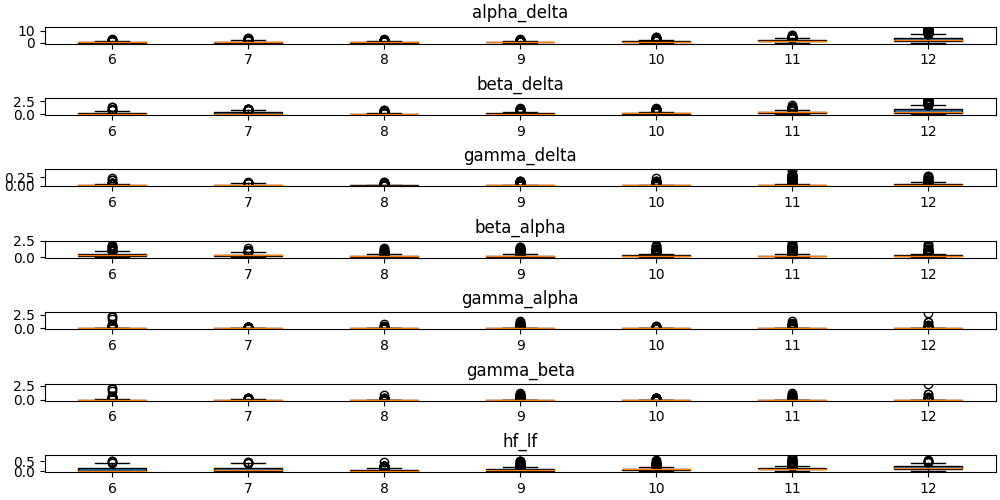

In [9]:
for i in range(4):
    axes[i].set_ylim(0,1)

fig, axes = plt.subplots(7, constrained_layout = True)

axes[0].boxplot(alpha_delta[start : end], positions=range(start, end), patch_artist=True)
axes[0].set_title('alpha_delta')
axes[1].boxplot(beta_delta[start : end], positions=range(start, end), patch_artist=True)
axes[1].set_title('beta_delta')
axes[2].boxplot(gamma_delta[start : end], positions=range(start, end), patch_artist=True)
axes[2].set_title('gamma_delta')
axes[3].boxplot(beta_alpha[start : end], positions=range(start, end), patch_artist=True)
axes[3].set_title('beta_alpha')
axes[4].boxplot(gamma_alpha[start : end], positions=range(start, end), patch_artist=True)
axes[4].set_title('gamma_alpha')
axes[5].boxplot(gamma_beta[start : end], positions=range(start, end), patch_artist=True)
axes[5].set_title('gamma_beta')
axes[6].boxplot(hf_lf[start : end], positions=range(start, end), patch_artist=True)
axes[6].set_title('hf_lf')

Text(0.5, 1.0, 'f_central')

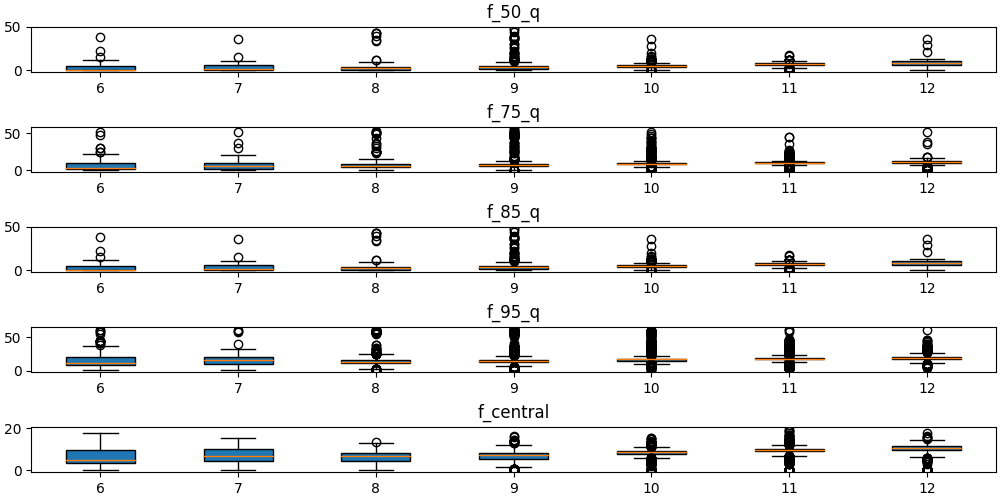

In [10]:
for i in range(7):
    axes[i].set_ylim(0,1)

fig, axes = plt.subplots(5, constrained_layout = True)

axes[0].boxplot(f_50_q[start : end], positions=range(start, end), patch_artist=True)
axes[0].set_title('f_50_q')
axes[1].boxplot(f_75_q[start : end], positions=range(start, end), patch_artist=True)
axes[1].set_title('f_75_q')
axes[2].boxplot(f_50_q[start : end], positions=range(start, end), patch_artist=True)
axes[2].set_title('f_85_q')
axes[3].boxplot(f_95_q[start : end], positions=range(start, end), patch_artist=True)
axes[3].set_title('f_95_q')
axes[4].boxplot(f_central[start : end], positions=range(start, end), patch_artist=True)
axes[4].set_title('f_central')

Text(0.5, 1.0, 'be')

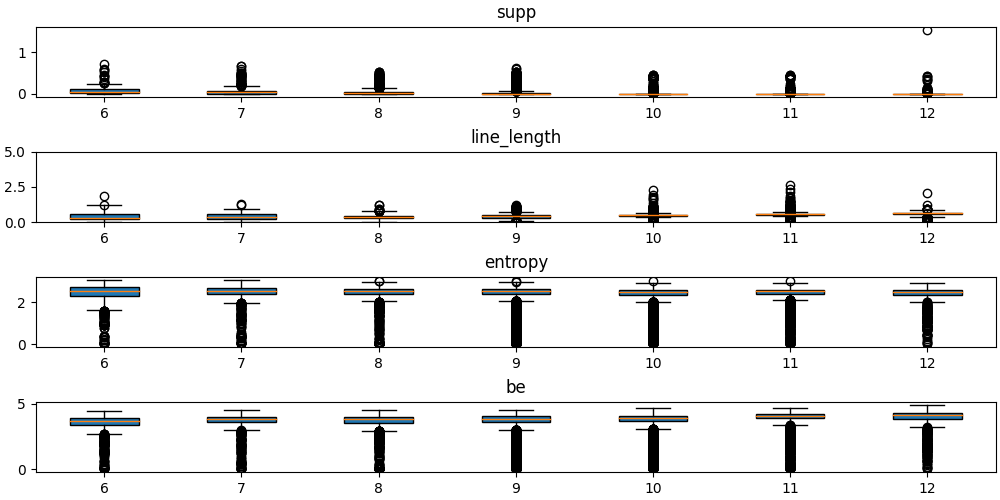

In [11]:
for i in range(4):
    axes[i].set_ylim(0,20)

fig, axes = plt.subplots(4, constrained_layout = True)

axes[0].boxplot(supp[start : end], positions=range(start, end), patch_artist=True)
axes[0].set_title('supp')
axes[1].boxplot(line_length[start : end], positions=range(start, end), patch_artist=True)
axes[1].set_title('line_length')
axes[1].set_ylim(0,5)
axes[2].boxplot(entropy[start : end], positions=range(start, end), patch_artist=True)
axes[2].set_title('entropy')
axes[3].boxplot(be[start : end], positions=range(start, end), patch_artist=True)
axes[3].set_title('be')

### Format data into sample for the classifier
XGBoost can work with different datatype entries. Including their own type. It accepts np.ndarray which is the type chosen here. 
For a classification task, the format is as follow:
- X: (n_samples, n_features)
- y: (n_samples,)

For instance if n_samples = 5 and n_features = 3:

X = [[f01, f02, f03],
     [f11, f12, f13],
     [f21, f22, f23],
     [f31, f32, f33],
     [f41, f42, f43]]

y = [c0, c1, c2, c3, c4]

_Currently the data is stored in a dictionnary where each key is a metric name. The name of the metric gives access to another dictionnary where each key is an integer representing the stae. The integer give access to a list of the value of this particular metrics for this particular state._

In [ ]:
def format_data(D, states_range = None):

    keys = list(D.keys()) # convert to list to assess the ken of len(D[keys[0]][i]), otherwise error with keys[0]
    X = []
    y = []
    if states_range == None:
        for i in range(22):
            N_samples_for_current_state = len(D[keys[0]][i])
            print(f'Number of samples in state {i}: {N_samples_for_current_state}')
            for j in range(N_samples_for_current_state):
                L = [] # line vector that will contain all features for this sample positionned at the jth element of state i
                y.append(i)
                for key in keys:
                    L.append(D[key][i][j])
                X.append(L)
    
    elif type(states_range[0]) == int:
        for i in range(states_range[0], states_range[1]): # first state should be lower than second
            N_samples_for_current_state = len(D[keys[0]][i])
            print(f'Number of samples in state {i}: {N_samples_for_current_state}')
            for j in range(N_samples_for_current_state):
                L = [] # line vector that will contain all features for this sample positionned at the jth element of state i
                y.append(i - states_range[0])
                for key in keys:
                    L.append(D[key][i][j])
                X.append(L)        
    
    return np.array(X), np.array(y)

In [32]:
X_6_12, y_6_12 = format_data(D_data, states_range = [6, 13])
print(f'X shape is: {np.shape(X_6_12)}')
print(f'y shape is: {np.shape(y_6_12)}')

Number of samples in state 6: 759
Number of samples in state 7: 1475
Number of samples in state 8: 1820
Number of samples in state 9: 5912
Number of samples in state 10: 8929
Number of samples in state 11: 5088
Number of samples in state 12: 1080
X shape is: (25063, 20)
y shape is: (25063,)


## Train classifier

### XGBoost classifier

In [40]:
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, cross_validate
import xgboost as xgb

In [52]:
# NOTE: shuffle dataset as it is currently ordered
X_6_12, y_6_12 = shuffle(X_6_12, y_6_12, random_state=0)
print(np.shape(X_6_12))

(25063, 20)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X_6_12, y_6_12, stratify=y_6_12, random_state=94)

# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:1.59039
[1]	validation_0-mlogloss:1.39530
[2]	validation_0-mlogloss:1.26093
[3]	validation_0-mlogloss:1.16787
[4]	validation_0-mlogloss:1.09621
[5]	validation_0-mlogloss:1.03617
[6]	validation_0-mlogloss:0.99229
[7]	validation_0-mlogloss:0.95651
[8]	validation_0-mlogloss:0.92747
[9]	validation_0-mlogloss:0.90466
[10]	validation_0-mlogloss:0.88426
[11]	validation_0-mlogloss:0.86790
[12]	validation_0-mlogloss:0.85566
[13]	validation_0-mlogloss:0.84052
[14]	validation_0-mlogloss:0.83060
[15]	validation_0-mlogloss:0.82104
[16]	validation_0-mlogloss:0.81159
[17]	validation_0-mlogloss:0.80387
[18]	validation_0-mlogloss:0.79646
[19]	validation_0-mlogloss:0.79072
[20]	validation_0-mlogloss:0.78428
[21]	validation_0-mlogloss:0.77766
[22]	validation_0-mlogloss:0.77305
[23]	validation_0-mlogloss:0.76820
[24]	validation_0-mlogloss:0.76145
[25]	validation_0-mlogloss:0.75718
[26]	validation_0-mlogloss:0.75466
[27]	validation_0-mlogloss:0.75130
[28]	validation_0-mlogloss:0.7

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy

In [58]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.45%


Scaler

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_6_12_new = scaler.fit_transform(X_6_12, y_6_12)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_6_12_new, y_6_12, stratify=y_6_12, random_state=94)

# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:1.59039
[1]	validation_0-mlogloss:1.39530
[2]	validation_0-mlogloss:1.26093
[3]	validation_0-mlogloss:1.16787
[4]	validation_0-mlogloss:1.09621
[5]	validation_0-mlogloss:1.03617
[6]	validation_0-mlogloss:0.99229
[7]	validation_0-mlogloss:0.95651
[8]	validation_0-mlogloss:0.92747
[9]	validation_0-mlogloss:0.90466
[10]	validation_0-mlogloss:0.88426
[11]	validation_0-mlogloss:0.86790
[12]	validation_0-mlogloss:0.85566
[13]	validation_0-mlogloss:0.84052
[14]	validation_0-mlogloss:0.83060
[15]	validation_0-mlogloss:0.82104
[16]	validation_0-mlogloss:0.81159
[17]	validation_0-mlogloss:0.80387
[18]	validation_0-mlogloss:0.79646
[19]	validation_0-mlogloss:0.79072
[20]	validation_0-mlogloss:0.78428
[21]	validation_0-mlogloss:0.77766
[22]	validation_0-mlogloss:0.77305
[23]	validation_0-mlogloss:0.76820
[24]	validation_0-mlogloss:0.76145
[25]	validation_0-mlogloss:0.75718
[26]	validation_0-mlogloss:0.75466
[27]	validation_0-mlogloss:0.75130
[28]	validation_0-mlogloss:0.7

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [62]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.75%


In [42]:
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=94)

clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=3)

results = {}

for train, test in cv.split(X_6_12, y_6_12):
    print(train)
    X_train = X_6_12[train]
    X_test = X_6_12[test]
    y_train = y_6_12[train]
    y_test = y_6_12[test]
    est, train_score, test_score = fit_and_score(
        clone(clf), X_train, X_test, y_train, y_test
    )
    results[est] = (train_score, test_score)

[    2     3     4 ... 25060 25061 25062]


TypeError: only integer scalar arrays can be converted to a scalar index

In [63]:
from collections import Counter

print(Counter(y_6_12))

Counter({4: 8929, 3: 5912, 5: 5088, 2: 1820, 1: 1475, 6: 1080, 0: 759})


In [65]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_6_12_new, y_6_12)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({2: 8929, 1: 8929, 3: 8929, 4: 8929, 5: 8929, 6: 8929, 0: 8929})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, random_state=94)

# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:1.59039
[1]	validation_0-mlogloss:1.39530
[2]	validation_0-mlogloss:1.26093
[3]	validation_0-mlogloss:1.16787
[4]	validation_0-mlogloss:1.09621
[5]	validation_0-mlogloss:1.03617
[6]	validation_0-mlogloss:0.99229
[7]	validation_0-mlogloss:0.95651
[8]	validation_0-mlogloss:0.92747
[9]	validation_0-mlogloss:0.90466
[10]	validation_0-mlogloss:0.88426
[11]	validation_0-mlogloss:0.86790
[12]	validation_0-mlogloss:0.85566
[13]	validation_0-mlogloss:0.84052
[14]	validation_0-mlogloss:0.83060
[15]	validation_0-mlogloss:0.82104
[16]	validation_0-mlogloss:0.81159
[17]	validation_0-mlogloss:0.80387
[18]	validation_0-mlogloss:0.79646
[19]	validation_0-mlogloss:0.79072
[20]	validation_0-mlogloss:0.78428
[21]	validation_0-mlogloss:0.77766
[22]	validation_0-mlogloss:0.77305
[23]	validation_0-mlogloss:0.76820
[24]	validation_0-mlogloss:0.76145
[25]	validation_0-mlogloss:0.75718
[26]	validation_0-mlogloss:0.75466
[27]	validation_0-mlogloss:0.75130
[28]	validation_0-mlogloss:0.7

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [67]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.75%
